In [14]:
# alternating optimization simulator:
# 1. Define the non-convex objective function that you want to optimize.
# 2. Define the convex constraints.
# 3. Initialize the optimization variables.
# 4. Alternate between optimizing with respect to one set of variables while keeping the other set fixed.

#Each subproblem optimizes one set of variables while keeping the others fixed, 
#and this process alternates between the sets of variables until convergence.

In [82]:
import cvxpy as cp
import numpy as np

# Parameters
W = pow(10, 6)  # bandwidth in Hz
beta = 0.5  # Lyapunov parameter
P_max = 1  # Maximum power of TX1
B_max = 360000  # Maximum energy of TX2 in Joules
eta = 0.1  # Energy harvesting parameter
N0 = pow(10, -15)  # Noise power in watt
lambda_a = 1000  # Rate for Poisson process

# Initial values for Q1(t), Q2(t), and B(t)
Q1_t = 1  # Initial value for Q1(t), ensuring it starts greater than 0
Q2_t = 1  # Initial value for Q2(t), ensuring it starts greater than 0
B_t = 0  # Initial value for B(t)

# Randomly generated values
a1_t = np.random.poisson(lambda_a)
a2_t = np.random.poisson(lambda_a)
h1_t = np.random.exponential(1)
h2_t = np.random.exponential(1)
h_eh_t = np.random.exponential(1)

# Calculated parameters based on random variables
xi1_t = abs(h1_t)**2 / N0
xi2_t = W * np.log2(1 + abs(B_max) * abs(h2_t)**2 / N0)
xi3_t = abs(h_eh_t)**2 * P_max
xi4 = 2 * a2_t * xi2_t + beta * abs(B_max)

# Initial guess for variables
x1 = cp.Parameter(nonneg=True)
x2 = cp.Parameter(nonneg=True)
x3 = cp.Parameter(nonneg=True)
x4 = cp.Parameter(nonneg=True)

# Randomly initialize x1, x2, x3 with the constraint x1 + x2 + x3 <= 1
x1_val = np.random.rand()  # Random initial guess for x1
x2_val = np.random.rand() * (1 - x1_val)  # Random initial guess for x2
x3_val = np.random.rand() * (1 - x1_val - x2_val)  # Random initial guess for x3
x4_val = np.random.rand() * P_max  # Random initial guess for x4

# Ensure x3 is nonnegative and within [0, 1]
if x3_val < 0:
    x3_val = 0
elif x3_val > 1:
    x3_val = 1 - x1_val - x2_val  # Adjust x3 to satisfy x1 + x2 + x3 <= 1

# Ensure x2 is nonnegative and within [0, 1]
if x2_val < 0:
    x2_val = 0
elif x2_val > 1:
    x2_val = 1 - x1_val - x3_val  # Adjust x3 to satisfy x1 + x2 + x3 <= 1

# Set initial parameter values
x1.value = x1_val
x2.value = x2_val
x3.value = x3_val
x4.value = x4_val

# Define the objective function
J = (
    -2 * W**2 * x1**2 * (cp.log(1 + xi1_t * x4) / cp.log(2))**2
    - 2 * W * a1_t * x1 * (cp.log(1 + xi1_t * x4) / cp.log(2))
    - 2 * xi2_t**2 * x3**2
    - xi4 * x3
    - beta * x1 * x4
)

# Constraints (initial setup)
constraints = [
    x1 + x2 + x3 <= 1,
    x1 >= 0, x1 <= 1 - x2 - x3,
    x2 >= 0, x2 <= 1 - x1 -x3,
    x3 >= 0, x3 <= 1 - x1 - x2,
    x4 >= 0, x4 <= P_max,
    W * (cp.log(1 + xi1_t * x4) / cp.log(2)) * x1 <= Q1_t,
    xi2_t * x3 <= Q2_t,
    B_max * x3 <= B_t  # Ensure B_t remains nonnegative
]

# Define the problem
problem = cp.Problem(cp.Minimize(J), constraints)

# Tolerance for convergence
tolerance = 1e-6

# Iterative optimization loop
while True:
    # Save current values for convergence check
    x1_old = x1_val
    x2_old = x2_val
    x3_old = x3_val
    x4_old = x4_val
    
    # Step 1: Optimize x1 with fixed x2, x3, x4
    problem.solve()
    x1_val = x1.value
    
    # Step 2: Optimize x2 with fixed x1, x3, x4
    problem.solve()
    x2_val = x2.value
    
    # Step 3: Optimize x3 with fixed x1, x2, x4
    problem.solve()
    x3_val = x3.value
    
    # Step 4: Optimize x4 with fixed x1, x2, x3
    problem.solve()
    x4_val = x4.value
    
    # Check convergence
    if (abs(x1_old - x1_val) < tolerance and
        abs(x2_old - x2_val) < tolerance and
        abs(x3_old - x3_val) < tolerance and
        abs(x4_old - x4_val) < tolerance):
        break

# Print final values
print(f"Final x1: {x1_val}")
print(f"Final x2: {x2_val}")
print(f"Final x3: {x3_val}")
print(f"Final x4: {x4_val}")

# Update Q1_t, Q2_t, B_t based on final values
Q1_t = Q1_t - W * x1_val * (np.log(1 + xi1_t * x4_val) / np.log(2)) + a1_t
Q2_t = Q2_t - xi2_t * x3_val + a2_t
B_t = (B_t - B_max * x3_val) + eta * x2_val * (xi3_t - abs(h_eh_t)**2 * x4_val)



# Print updated values
print(f"Updated Q1(t): {Q1_t}")
print(f"Updated Q2(t): {Q2_t}")
print(f"Updated B(t): {B_t}")


Final x1: 0.9978616332068903
Final x2: 0.0009254631298103858
Final x3: 0.0006570946953688508
Final x4: 0.7692841401049711
Updated Q1(t): -51821093.92968184
Updated Q2(t): -40498.587295337435
Updated B(t): -236.55402846971867


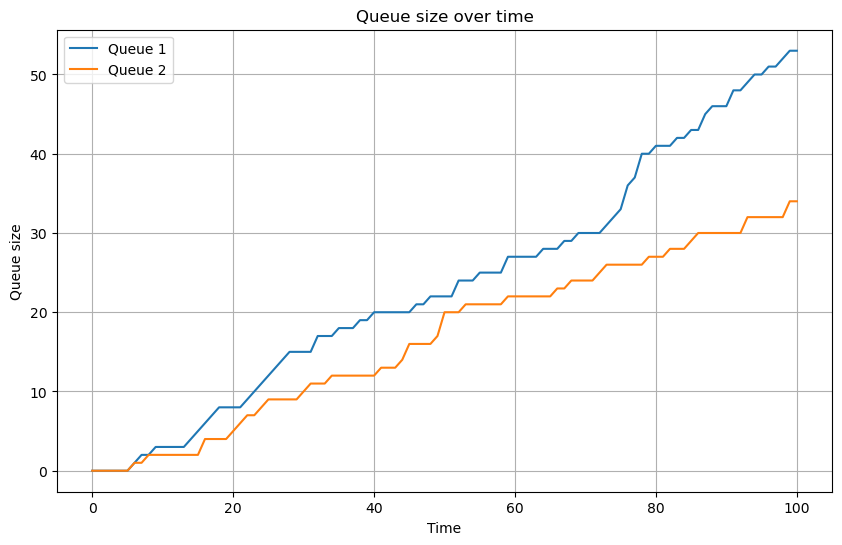

In [84]:
import numpy as np

# Initialize parameters
T = 100  # Number of time steps
lambda_1 = 0.5  # Arrival rate for queue 1
lambda_2 = 0.3  # Arrival rate for queue 2

# Initialize queues
Q1 = np.zeros(T+1)
Q2 = np.zeros(T+1)

# Simulate the system
for t in range(T):
    # Generate arrivals (according to a Poisson process)
    a1_t = np.random.poisson(lambda_1)
    a2_t = np.random.poisson(lambda_2)
    
    # Generate data transferred
    D1_t = np.random.randint(0, 1)  # Example: random data transferred for queue 1
    D2_t = np.random.randint(0, 1)  # Example: random data transferred for queue 2
    
    # Update queues
    Q1[t+1] = Q1[t] - D1_t + a1_t
    Q2[t+1] = Q2[t] - D2_t + a2_t

# Plotting the queues over time
import matplotlib.pyplot as plt

time = np.arange(T+1)

plt.figure(figsize=(10, 6))
plt.plot(time, Q1, label='Queue 1')
plt.plot(time, Q2, label='Queue 2')
plt.xlabel('Time')
plt.ylabel('Queue size')
plt.title('Queue size over time')
plt.legend()
plt.grid(True)
plt.show()
